# ALBERT model trained on the `train_data_cleaned` dataset

In [1]:
!pip install torch
!pip install transformers
!pip install sentencepiece

In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Preparing the dataset

In [3]:
# Path to a clean dataset
dataset_path = '/kaggle/input/toxic-comments/train_data_cleaned.csv'

# Load the dataset into a DataFrame
df_train = pd.read_csv(dataset_path)

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,token_count
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,54
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0,20
2,000113f07ec002fd,"hey man, im really not trying to edit war. its...",0,0,0,0,0,0,48
3,0001b41b1c6bb37e,more i cant make any real suggestions on impro...,0,0,0,0,0,0,119
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,17


In [4]:
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,token_count
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,79.119602
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,114.629912
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,89.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1373.000000


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159562 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
 8   token_count    159571 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 11.0+ MB


In [6]:
# Check the number of labels for each class
column_labels = df_train.columns.tolist()[2:8]
label_counts = df_train[column_labels].sum().sort_values(ascending=False)

label_counts

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

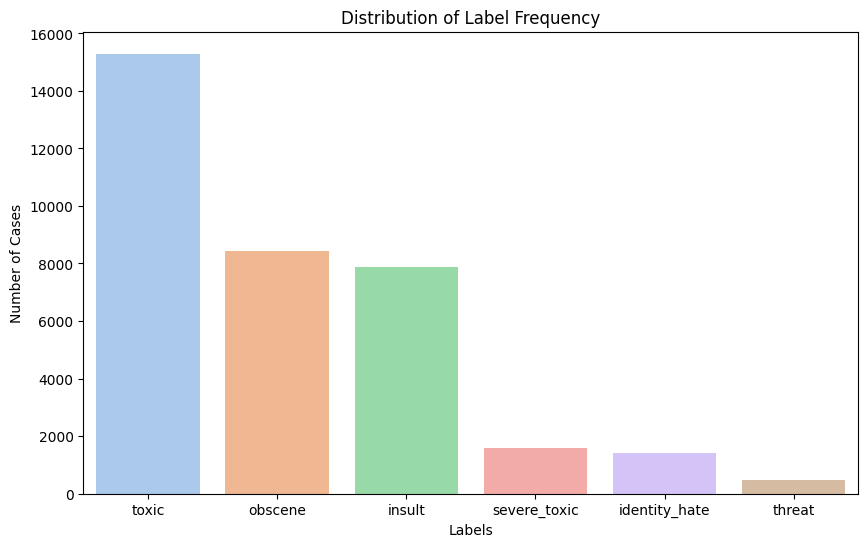

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the class distribution of the 'label' column
plt.figure(figsize=(10, 6))

ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette='pastel')

# Add labels and title to the plot
plt.xlabel('Labels')
plt.ylabel('Number of Cases')
plt.title('Distribution of Label Frequency')

plt.show()

The dataset shows a significant class imbalance across the different toxicity labels. For instance, the toxic class is represented by 15,294 examples, while the threat class has only 478 examples, making it highly underrepresented. Other categories such as severe toxic (1,595), identity hate (1,405), and insult (7,877) are also much smaller compared to the more frequent classes like toxic and obscene (8,449).

This imbalance could lead the model to favor the majority classes, which may result in poor performance when predicting minority classes. To address this issue, it will be important to apply class weights during the training process, specifically in the loss function. By assigning higher weights to the minority classes, the model will learn to focus more on these underrepresented categories, improving its ability to make accurate predictions across all toxicity levels.

In [8]:
# Split data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    df_train['comment_text'],
    df_train.iloc[:, 2:8],
    test_size=0.20,
    random_state=42
)

In [9]:
print(f'Training data shape: {train_data.shape}')
print(f'Training labels shape: {train_labels.shape}')
print(f'Validation data shape: {val_data.shape}')
print(f'Validation labels shape: {val_labels.shape}')

Training data shape: (127656,)
Training labels shape: (127656, 6)
Validation data shape: (31915,)
Validation labels shape: (31915, 6)


## Model preparation and training

In [10]:
# Token and Encode Function
def tokenize_and_encode(tokenizer, comments, labels, max_length=512):
    # Initialize empty lists to store tokenized inputs and attention masks
    input_ids = []
    attention_masks = []
    
    # Iterate through each comment in the 'comments' list
    for comment in comments:
        # Tokenize and encode the comment using the ALBERT tokenizer
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,  # Add special tokens like [CLS] and [SEP]
            max_length=max_length,
            padding='max_length',  # Add padding to the maximum size
            truncation=True,  # If the comment is longer than max_length, cut it off
            return_attention_mask=True,  # Return attention mask to mask padded tokens
            return_tensors='pt'  # Return PyTorch tensors
        )
        
        # Append the tokenized input and attention mask to their respective lists
        input_ids.append(encoded_dict['input_ids'].squeeze().tolist())
        attention_masks.append(encoded_dict['attention_mask'].squeeze().tolist())
    
    # Convert to a PyTorch tensor
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    # Return the tokenized inputs, attention masks, and labels as PyTorch tensors
    return input_ids, attention_masks, labels

In [11]:
# Token Initialization
tokenizer = AlbertTokenizer.from_pretrained('/kaggle/input/albert-base-v2')

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
# Model Initialization
model = AlbertForSequenceClassification.from_pretrained('/kaggle/input/albert-base-v2', num_labels=6)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Check for NaN values in train_data
print("NaN values in train_data:")
print(train_data.isnull().sum())

# Drop rows with NaN values in train_data
train_data_cleaned = train_data.dropna()

# Filter train_labels to match the cleaned train_data
train_labels_cleaned = train_labels.loc[train_data_cleaned.index]

# Recheck for NaN values after cleaning
print("NaN values in train_data_cleaned:")
print(train_data_cleaned.isnull().sum())
print("NaN values in train_labels_cleaned:")
print(train_labels_cleaned.isnull().sum())

NaN values in train_data:
7
NaN values in train_data_cleaned:
0
NaN values in train_labels_cleaned:
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [14]:
# Check for NaN values in val_data
print("NaN values in val_data:")
print(val_data.isnull().sum())

# Drop rows with NaN values in val_data
val_data_cleaned = val_data.dropna()

# Filter val_labels to match the cleaned val_data
val_labels_cleaned = val_labels.loc[val_data_cleaned.index]

# Recheck for NaN values after cleaning
print("NaN values in val_data_cleaned:")
print(val_data_cleaned.isnull().sum())
print("NaN values in val_labels_cleaned:")
print(val_labels_cleaned.isnull().sum())

NaN values in val_data:
2
NaN values in val_data_cleaned:
0
NaN values in val_labels_cleaned:
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [15]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available! The model will use the GPU.")
else:
    print("CUDA is not available. The model will use the CPU.")

CUDA is available! The model will use the GPU.


In [16]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
    tokenizer,
    train_data_cleaned,
    train_labels_cleaned.values
)

In [17]:
# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer,
    val_data_cleaned,
    val_labels_cleaned.values
)

In [18]:
print('Training Comments :',train_data_cleaned.shape)
print('Input Ids         :',input_ids.shape)
print('Attention Mask    :',attention_masks.shape)
print('Labels            :',labels.shape)

Training Comments : (127649,)
Input Ids         : torch.Size([127649, 512])
Attention Mask    : torch.Size([127649, 512])
Labels            : torch.Size([127649, 6])


In [19]:
# Check an encoded text with the corresponding text and labels (e.g., comment #25)
i = 25
print('Example comment:',train_data_cleaned.values[i])
print('\nInput Ids:\n',input_ids[i])
print('\nDecoded Ids:\n',tokenizer.decode(input_ids[i]))
print('\nAttention Mask:\n',attention_masks[i])
print('\nLabels:',labels[i])

Example comment: you, and no one else, have explained why this one word is vandalism. it cetainly appiles to him, and you are now saying that people have to decide wheter it applies by some sort of vote that is certainly not neutrality. on what basis is this word vanalism

Input Ids:
 tensor([    2,    42,    15,    17,    90,    53,   962,    15,    57,  2897,
          483,    48,    53,   833,    25, 29359,     9,    32,  4000,  5851,
          102,  4865,  3599,    18,    20,    61,    15,    17,    42,    50,
          130,  1148,    30,   148,    57,    20,  4073, 11153, 12382,    32,
        13169,    34,   109,  2058,    16,  2018,    30,    25,  3850,    52,
        23079,     9,    27,    98,  2239,    25,    48,   833,  1019,   192,
          756,     3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            

In [20]:
from torch.utils.data import DataLoader, TensorDataset

# Creating DataLoader
batch_size = 8

# Training set
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation set
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# Check the train_loader data
print('Batch Size :',train_loader.batch_size)
Batch = next(iter(train_loader))
print('Each Input ids shape :', Batch[0].shape)
print('Input ids :\n', Batch[0][0])
print('Corresponding Decoded text:\n', tokenizer.decode(Batch[0][0]))
print('Corresponding Attention Mask :\n', Batch[1][0])
print('Corresponding Label:', Batch[2][0])

Batch Size : 8
Each Input ids shape : torch.Size([8, 512])
Input ids :
 tensor([    2,    40, 22264, 18341,    42,   395,    15,   193,   102,    15,
           80,    50,    91,   119,    81, 12149,   130,     9,    31,  2321,
           30,  1364,    55,    40, 11647,   422,  4052,    15,    17,    31,
          277,    14, 10660,    16,   602,    88,    14,  1063,  5984,    18,
           25,  1389,     9,   630,    30,   448,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,

In [22]:
from torch.optim import AdamW

# Optimizer setup
optimizer = AdamW(model.parameters(), lr=2e-5)

In [23]:
# Calculate label counts from the cleaned training dataset
label_counts = train_labels_cleaned.sum(axis=0).values  # Sum the counts of each label
total_count = len(train_labels_cleaned)  # Get the total number of samples

# Calculate class weights
class_weights = total_count / (len(label_counts) * label_counts)

# Create a DataFrame to display counts and weights
class_data = pd.DataFrame({
    'Class': column_labels,
    'Count': label_counts,
    'Weight': class_weights
})

# Sort the DataFrame by 'Count' in descending order
class_data = class_data.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Display the DataFrame
class_data

,Class,Count,Weight
0,toxic,12238,1.738424
1,obscene,6734,3.159316
2,insult,6263,3.396908
3,severe_toxic,1274,16.699241
4,identity_hate,1111,19.149265
5,threat,404,52.660479


In [24]:
from torch import nn

# Convert class_weights to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Update the loss function using class weights
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

In [25]:
# Function to train the model
def train_model_with_class_weights(model, train_loader, optimizer, device, num_epochs, loss_fn):
        
    # Loop through the specified number of epochs
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0  # Initialize total loss for the current epoch

        # Loop through the batches in the training data
        for i, batch in enumerate(train_loader):
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            optimizer.zero_grad()  # Clear the gradients from the previous step to prevent accumulation
            
            # Model output        
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Convert labels to Float type
            labels = labels.float().to(device)
                        
            # Calculate losses based on class weights        
            loss = loss_fn(logits, labels)
            total_loss += loss.item()
            
            # Backward error propagation        
            loss.backward()
            optimizer.step()
            
        # Clear GPU memory
        torch.cuda.empty_cache()
            
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        
        # Disable gradient computation during validation
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [t.to(device) for t in batch]

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                
                # Convert labels to Float type
                labels = labels.float().to(device)
                
                # Validation losses based on class weights
                loss = loss_fn(logits, labels)
                val_loss += loss.item()

        # Print the average loss for the current epoch
        print(f'Epoch {epoch+1}: ')
        print(f'  Training Loss: {total_loss/len(train_loader)}')
        print(f'  Validation Loss: {val_loss/len(val_loader)}')

In [26]:
model = nn.DataParallel(model)
model.to(device)

# Call the function to train the model
train_model_with_class_weights(model, train_loader, optimizer, device, num_epochs=3, loss_fn=loss_fn)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1: 
  Training Loss: 0.49521810765026064
  Validation Loss: 0.3865724713148264
Epoch 2: 
  Training Loss: 0.37997473960560785
  Validation Loss: 0.3462504455022033
Epoch 3: 
  Training Loss: 0.3488366957742078
  Validation Loss: 0.3657180808724971


## Save the model

In [29]:
import os

# Define the output directory for the model and tokenizer
output_dir = "/kaggle/working/toxic_albert_model"

# Save the model's state dictionary and configuration
model.module.save_pretrained(output_dir)
print(f"Model configuration saved to: {os.path.join(output_dir, 'config.json')}")

# Save the tokenizer's configuration and vocabulary
tokenizer.save_pretrained(output_dir)
print(f"Tokenizer configuration and vocabulary saved to: {output_dir}")

# Save the model weights separately
weights_path = os.path.join(output_dir, 'toxic_albert_model_weights.pth')
torch.save(model.module.state_dict(), weights_path)
print(f"Model weights saved to: {weights_path}")

Model configuration saved to: /kaggle/working/toxic_albert_model/config.json
Tokenizer configuration and vocabulary saved to: /kaggle/working/toxic_albert_model
Model weights saved to: /kaggle/working/toxic_albert_model/toxic_albert_model_weights.pth


In [30]:
from safetensors.torch import save_file

# Save the model in safetensors format
safetensors_path = os.path.join(output_dir, 'model.safetensors')
save_file(model.state_dict(), safetensors_path)
print(f"Model saved in Safetensors format at: {safetensors_path}")

Model saved in Safetensors format at: /kaggle/working/toxic_albert_model/model.safetensors


In [31]:
# Create a dictionary to hold both the model's state dict and the tokenizer
model_data = {
    'model_state_dict': model.state_dict(),
    'tokenizer_config': tokenizer,
}

# Save the entire model and tokenizer as a single .pt file
pt_file_path = os.path.join(output_dir, 'toxic_albert_model.pt')
torch.save(model_data, pt_file_path)

print(f"Model and tokenizer saved as a single .pt file at: {pt_file_path}")

Model and tokenizer saved as a single .pt file at: /kaggle/working/toxic_albert_model/toxic_albert_model.pt


In [32]:
import pickle

# Save the entire model using Pickle
pickle_path = os.path.join(output_dir, 'toxic_albert_model.pkl')
with open(pickle_path, 'wb') as fh:
    pickle.dump(model, fh)

print(f"Model saved as a Pickle file at: {pickle_path}")

Model saved as a Pickle file at: /kaggle/working/toxic_albert_model/toxic_albert_model.pkl


## Test the model on the `test_cleaned` dataset

In [33]:
# Path to a clean test dataset
test_dataset_path = '/kaggle/input/toxic-comments/test_claud.csv'

# Load the dataset into a DataFrame
df_test = pd.read_csv(test_dataset_path)

df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,thank you for understanding. i think very high...,0,0,0,0,0,0
1,000247e83dcc1211,dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,somebody will invariably try to add religion r...,0,0,0,0,0,0
3,0003e1cccfd5a40a,it says it right there that it is a type. the ...,0,0,0,0,0,0
4,00059ace3e3e9a53,"before adding a new product to the list, make ...",0,0,0,0,0,0


In [34]:
df_test.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000
mean,0.095189,0.005736,0.057692,0.003298,0.053565,0.011129
std,0.293478,0.075522,0.233161,0.057334,0.225160,0.104905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63978 entries, 0 to 63977
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             63978 non-null  object
 1   comment_text   63477 non-null  object
 2   toxic          63978 non-null  int64 
 3   severe_toxic   63978 non-null  int64 
 4   obscene        63978 non-null  int64 
 5   threat         63978 non-null  int64 
 6   insult         63978 non-null  int64 
 7   identity_hate  63978 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 3.9+ MB


In [36]:
# Extract the comment texts and labels from the test DataFrame
test_data = df_test['comment_text']
test_labels = df_test.iloc[:, 2:]

print(f'Test data shape: {test_data.shape}')
print(f'Test labels shape: {test_labels.shape}')

Test data shape: (63978,)
Test labels shape: (63978, 6)


In [37]:
# Sum the labels to get the total count for each class
label_counts_test = test_labels.sum(axis=0)

# Convert the NumPy array to a pandas Series
label_counts_test = pd.Series(label_counts_test)

# Sort the label counts in descending order
label_counts_test = label_counts_test.sort_values(ascending=False)

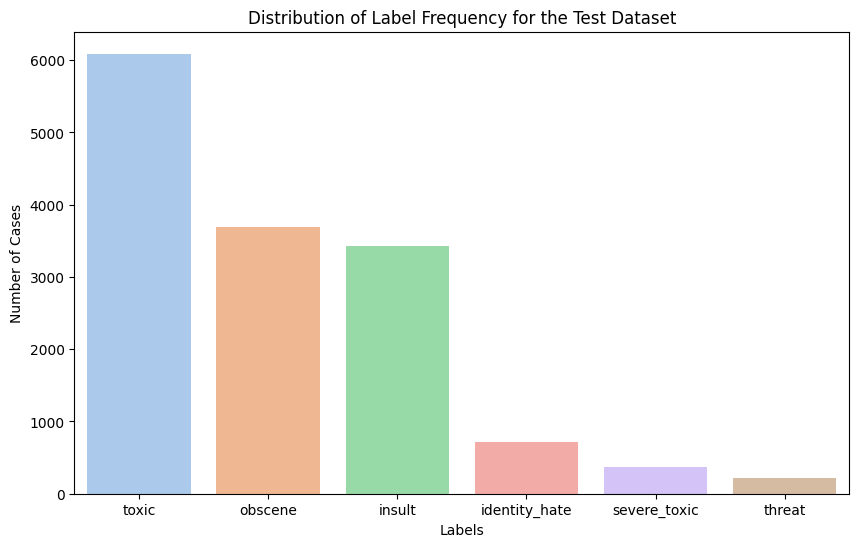

In [38]:
# Visualizing the class distribution of the 'label' column
plt.figure(figsize=(10, 6))

ax = sns.barplot(x=label_counts_test.index, y=label_counts_test.values, palette='pastel')

# Add labels and title to the plot
plt.xlabel('Labels')
plt.ylabel('Number of Cases')
plt.title('Distribution of Label Frequency for the Test Dataset')

plt.show()

In [39]:
# Check for NaN values in test_data
print("NaN values in test_data:")
print(test_data.isnull().sum())

# Drop rows with NaN values in test_data
test_data_cleaned = test_data.dropna()

# Filter test_labels to match the cleaned test_data
test_labels_cleaned = test_labels.loc[test_data_cleaned.index]

# Recheck for NaN values after cleaning
print("NaN values in test_data_cleaned:")
print(test_data_cleaned.isnull().sum())
print("NaN values in test_labels_cleaned:")
print(test_labels_cleaned.isnull().sum())

NaN values in test_data:
501
NaN values in test_data_cleaned:
0
NaN values in test_labels_cleaned:
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [40]:
# Tokenize and Encode the comments and labels for the test set
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
    tokenizer,
    test_data_cleaned,
    test_labels_cleaned.values
)

In [41]:
# Creating DataLoader for the testing dataset
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [42]:
# Evaluate the model
def evaluate_model(model, test_loader, device, label_names):
    model.eval()  # Set the model to evaluation mode

    true_labels = []  # List to store true labels
    predicted_probs = []  # List to store predicted probabilities

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # Get model's predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            
            # Apply sigmoid for multilabel classification to get probabilities
            predicted_probs_batch = torch.sigmoid(outputs.logits)
            predicted_probs.append(predicted_probs_batch.cpu().numpy())

            # Store true labels for later evaluation
            true_labels_batch = labels.cpu().numpy()
            true_labels.append(true_labels_batch)

    # Combine predictions and labels for evaluation
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)

    # Apply threshold for binary classification (0.5 is commonly used)
    predicted_labels = (predicted_probs > 0.5).astype(int)

    # Calculate evaluation metrics for overall performance
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    f1 = f1_score(true_labels, predicted_labels, average='micro')

    # Calculate evaluation metrics for each label (class-specific)
    precision_per_label = precision_score(true_labels, predicted_labels, average=None)
    recall_per_label = recall_score(true_labels, predicted_labels, average=None)
    f1_per_label = f1_score(true_labels, predicted_labels, average=None)

    # Print the overall evaluation metrics
    print(f'Overall Accuracy: {accuracy:.4f}')
    print(f'Overall Precision: {precision:.4f}')
    print(f'Overall Recall: {recall:.4f}')
    print(f'Overall F1 Score: {f1:.4f}')

    # Print evaluation metrics for each label
    print("\nEvaluation per label:")
    for i, label in enumerate(label_names):
        print(f'{label}:')
        print(f'  Precision: {precision_per_label[i]:.4f}')
        print(f'  Recall: {recall_per_label[i]:.4f}')
        print(f'  F1 Score: {f1_per_label[i]:.4f}')

In [43]:
# List of labels in the dataset
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Call the function to evaluate the model on the test data
evaluate_model(model, test_loader, device, label_names)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Overall Accuracy: 0.8890
Overall Precision: 0.5869
Overall Recall: 0.5912
Overall F1 Score: 0.5891

Evaluation per label:
toxic:
  Precision: 0.6229
  Recall: 0.6583
  F1 Score: 0.6401
severe_toxic:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
obscene:
  Precision: 0.5857
  Recall: 0.6775
  F1 Score: 0.6282
threat:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
insult:
  Precision: 0.5288
  Recall: 0.6008
  F1 Score: 0.5625
identity_hate:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
